In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 1000
phi1 = 0.2
phi2 = 0.4
sigma_s = 1

Zadanie 1

In [3]:
def autokowariancja(h, x):
    n = len(x)
    mean_x = np.mean(x)
    return 1/n * np.sum((x[:n-abs(h)] - mean_x) * (x[abs(h):] - mean_x))

In [4]:
def estim_phi_sigma_s(trajectory, p):
    ps = np.arange(1,p+1,1)
    emp_autokow = np.transpose([autokowariancja(p_, trajectory) for p_ in ps])
    gamma_dash = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            gamma_dash[i][j] = autokowariancja(i - j, trajectory)
    phi_dash = np.linalg.inv(gamma_dash) @ emp_autokow
    sigma_s_dash = autokowariancja(0, trajectory) - np.transpose(phi_dash) @ emp_autokow
    return phi_dash, sigma_s_dash

In [5]:
mc = 1000
phi1s = []
phi2s = []
sigmas = []
for _ in range(mc):
    ar_process = ArmaProcess(ar = [1, -phi1, -phi2], ma = [1])
    trajectory = ar_process.generate_sample(nsample=n)
    phis, sigma_s = estim_phi_sigma_s(trajectory, 2)
    phi1s.append(phis[0])
    phi2s.append(phis[1])
    sigmas.append(sigma_s)

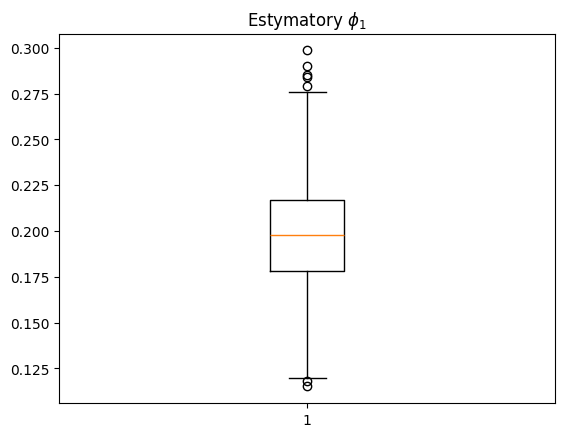

In [6]:
plt.boxplot(phi1s)
plt.title("Estymatory $\\phi_1$")
plt.show()

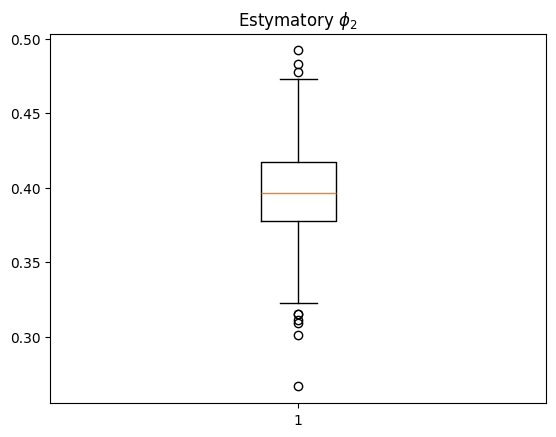

In [7]:
plt.boxplot(phi2s)
plt.title("Estymatory $\\phi_2$")
plt.show()

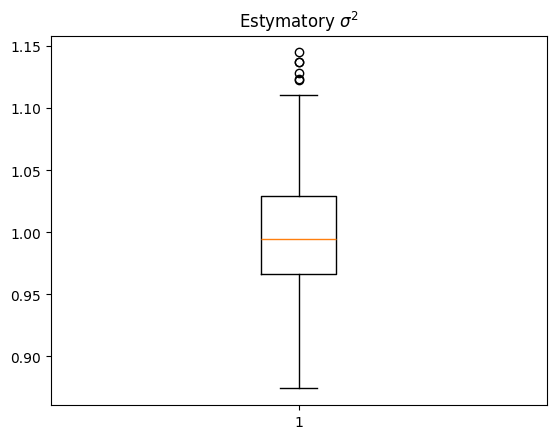

In [8]:
plt.boxplot(sigmas)
plt.title("Estymatory $\\sigma^2$")
plt.show()

Zadanie 2

In [45]:
phi = 0.1
sigma2 = 0.5
ns = np.arange(50,1050,50)
mc = 100

In [58]:
phi_nw_n = []
phi_yw_n = []
sigma2_nw_n = []
sigma2_yw_n = []
for n in ns:
    phi_nw = []
    phi_yw = []
    sigma2_nw = []
    sigma2_yw = []
    for _ in range(mc):
        ar_process = ArmaProcess(ar=[1, -phi])
        trajectory = ar_process.generate_sample(nsample=n, scale=np.sqrt(0.5))
        phis, sigma_s = estim_phi_sigma_s(trajectory, 1)
        phi_yw.append(phis[0])
        sigma2_yw.append(sigma_s)
        phinw = np.sum(trajectory[1:]*trajectory[:n-1]) / np.sum(trajectory**2)
        sigmanw = np.sum((trajectory[1:] - phinw * trajectory[:n-1])**2) / n
        sigma2_nw.append(sigmanw)
        phi_nw.append(phinw)
    phi_nw_n.append(phi_nw)
    phi_yw_n.append(phi_yw)
    sigma2_nw_n.append(sigma2_nw)
    sigma2_yw_n.append(sigma2_yw)
    

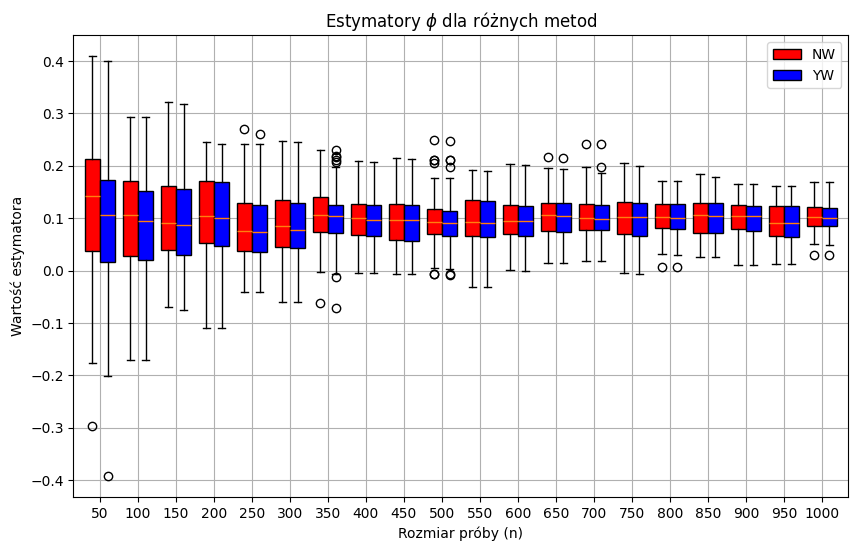

In [59]:
plt.figure(figsize=(10, 6))
positions_nw = [i - 0.2 for i in range(1, len(ns) + 1)]
positions_yw = [i + 0.2 for i in range(1, len(ns) + 1)]

bp1 = plt.boxplot(phi_nw_n, positions=positions_nw, widths=0.4, patch_artist=True, tick_labels=ns)
bp2 = plt.boxplot(phi_yw_n, positions=positions_yw, widths=0.4, patch_artist=True, tick_labels=ns)

for patch in bp1['boxes']:
    patch.set_facecolor("red")
for patch in bp2['boxes']:
    patch.set_facecolor("blue")

plt.xticks(range(1, len(ns) + 1), [f"{n}" for n in ns])
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['NW', 'YW'], loc='upper right')
plt.title("Estymatory $\\phi$ dla różnych metod")
plt.xlabel("Rozmiar próby (n)")
plt.ylabel("Wartość estymatora")
plt.grid(True)
plt.show()

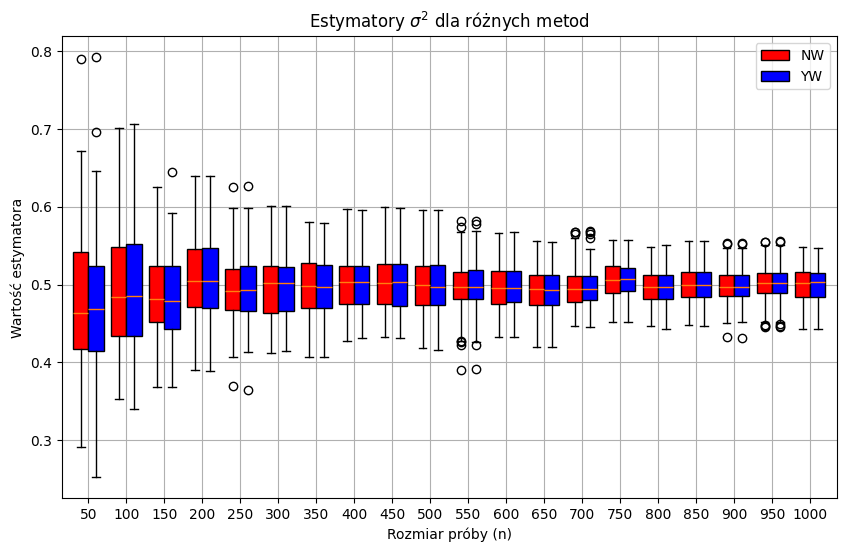

In [60]:
plt.figure(figsize=(10, 6))
positions_nw = [i - 0.2 for i in range(1, len(ns) + 1)]
positions_yw = [i + 0.2 for i in range(1, len(ns) + 1)]

bp1 = plt.boxplot(sigma2_nw_n, positions=positions_nw, widths=0.4, patch_artist=True, tick_labels=ns)
bp2 = plt.boxplot(sigma2_yw_n, positions=positions_yw, widths=0.4, patch_artist=True, tick_labels=ns)

for patch in bp1['boxes']:
    patch.set_facecolor("red")
for patch in bp2['boxes']:
    patch.set_facecolor("blue")

plt.xticks(range(1, len(ns) + 1), [f"{n}" for n in ns])
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['NW', 'YW'], loc='upper right')
plt.title("Estymatory $\\sigma^2$ dla różnych metod")
plt.xlabel("Rozmiar próby (n)")
plt.ylabel("Wartość estymatora")
plt.grid(True)
plt.show()

Zadanie 4

In [126]:
ar_process = ArmaProcess(ar = [1, -phi1, -phi2], ma = [1])
trajectory = ar_process.generate_sample(nsample=n)

In [127]:
def autokowariancja(h, x):
    n = len(x)
    mean_x = np.mean(x)
    return 1/n * np.sum((x[:n-abs(h)] - mean_x) * (x[abs(h):] - mean_x))

In [128]:
hs = np.arange(0,11,1)
emp_autokow = [autokowariancja(h, trajectory) for h in hs]

In [129]:
def teo_autokow(h,phi1, phi2, sigma_s):
    zero = sigma_s**2 * (1-phi2) / (1- phi2 - phi1**2 - phi1**2*phi2 - phi2**2 + phi2**3)
    if h == 0:
        return zero
    elif h == 1:
        return phi1 / (1 - phi2) * zero
    else:
        return teo_autokow(h - 1, phi1, phi2, sigma_s) * phi1 + teo_autokow(h-2, phi1, phi2, sigma_s) * phi2

In [130]:
teo = []
for h in hs:
    teo.append(teo_autokow(h, phi1, phi2, sigma_s))

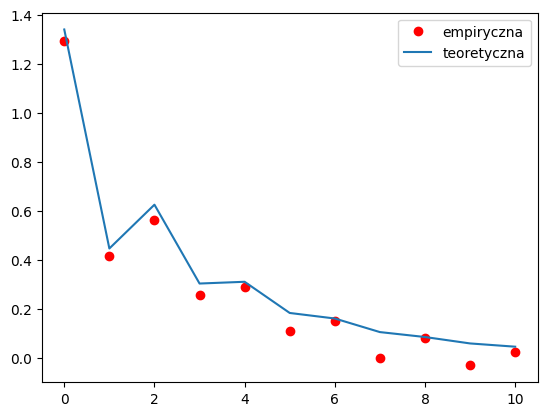

In [131]:
plt.plot(hs, emp_autokow, "ro", label="empiryczna")
plt.plot(hs, teo, label="teoretyczna")
plt.legend(loc="best")
plt.show()

Zadanie 5

In [89]:
ns = [50, 100, 500, 1000]
phi1 = 0.2
phi2 = 0.4
sigma = 1
mc = 100
ps = np.arange(0,11,1)

In [90]:
p_crits_n = []
for n in ns:
    p_crits = []
    for _ in range(mc):
        ar_process = ArmaProcess(ar = [1, -phi1, -phi2], ma=[1])
        trajectory = ar_process.generate_sample(nsample=n, scale=sigma)
        fpes = []
        for p in ps:
            _, sigma_2 = estim_phi_sigma_s(trajectory, int(p))
            fpe = sigma_2 * (n + p) / (n - p)
            fpes.append(fpe)
        p_crit = np.argmin(fpes)
        p_crits.append(p_crit)
    p_crits_n.append(p_crits)


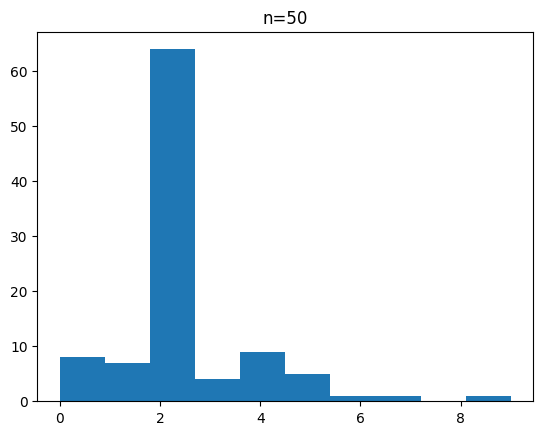

In [95]:
plt.hist(p_crits_n[0])
plt.title("n=50")
plt.show()

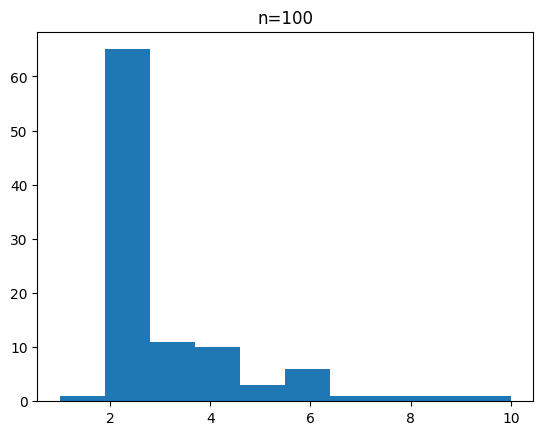

In [96]:
plt.hist(p_crits_n[1])
plt.title("n=100")
plt.show()

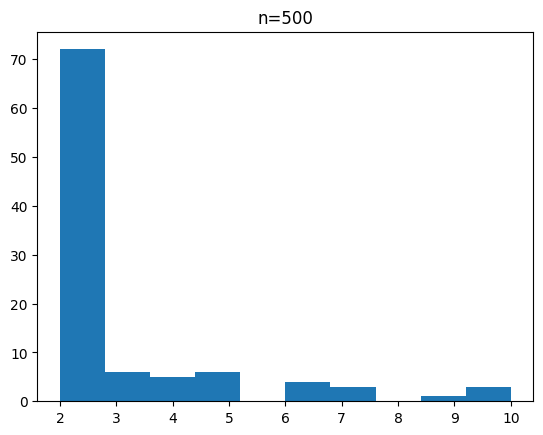

In [97]:
plt.hist(p_crits_n[2])
plt.title("n=500")
plt.show()

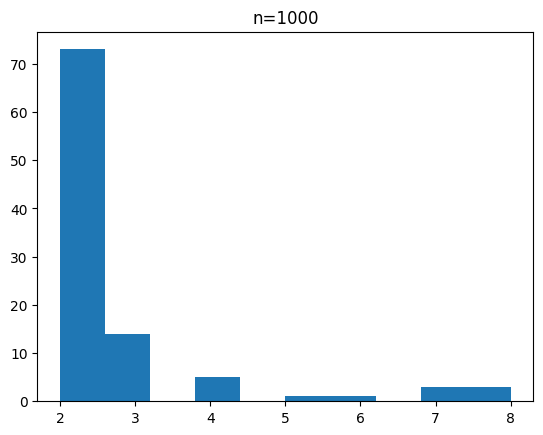

In [98]:
plt.hist(p_crits_n[3])
plt.title("n=1000")
plt.show()